This notebook accompanies the "Fast, high-fidelity LLM decoding with regex constraints" blog post ([blog post](https://vivien000.github.io/blog/journal/llm-decoding-with-regex-constraints.html), [technical appendix](https://github.com/vivien000/regex-constrained-decoding/blob/main/technical_appendix.pdf)).

# Technical prerequisites

In [ ]:
%%capture
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!apt install libgraphviz-dev
!pip install automata-lib[visual]
!pip install outlines==0.0.24
!pip install datasets
!pip install numba
!pip install peft bitsandbytes accelerate

import os
import re
import time
import json
import logging
import string
from collections import defaultdict
import transformers
from automata.fa.dfa import DFA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from outlines.models.transformers import TransformerTokenizer

sns.set(rc={'figure.figsize':(8,6)})
plt.rcParams['text.usetex'] = True

tokenizer = transformers.AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
tokenizer_outlines = TransformerTokenizer("mistralai/Mistral-7B-v0.1", padding_side="left")

# As far as I know, we cannot get the merge table from the HF Tokenizer object.
# I retrieve it from the tokenizer.json file in the model's HF repository.
!wget -nc https://huggingface.co/mistralai/Mistral-7B-v0.1/raw/main/tokenizer.json
with open("tokenizer.json", "r") as f:
    tokenizer_dict = json.load(f)

# `DirectMerge`

## Implementation: `DirectMerge`

Cf. Algorithms 1 and 2 of the technical appendix.

In [ ]:
import interegular

def get_token_id(token, tokenizer):
    """
    Return the token id of a given token.
    """
    return tokenizer.backend_tokenizer.model.token_to_id(token)

def get_token(token_id, tokenizer):
    """
    Return the token corresponding to a token id.
    """
    return tokenizer.backend_tokenizer.model.id_to_token(token_id)

def encode(s, tokenizer):
    """
    Encode a string with a tokenizer.
    """
    # The difference with the standard encode function is that we remove the
    # added blank space at the beginning of the string
    normalized = tokenizer.backend_tokenizer.normalizer.normalize_str(s)[1:]
    return [
        x.as_tuple()[0]
        for x in tokenizer.backend_tokenizer.model.tokenize(normalized)
    ]

class DirectMergeFSM(object):
    """
    Object to create and build a DFA with DirectMerge.
    """

    def __init__(self, fsm, letters, tokenizer):
        """
        Initialize the DFA with the character-level DFA.
        """
        self.tokenizer = tokenizer
        inverse_alphabet = {
            fsm.alphabet[x]: encode(x, tokenizer)[0]
            for x in fsm.alphabet
            if type(x) == str
            if x in letters
        }
        anything_else = {encode(c, tokenizer)[0] for c in letters if c not in inverse_alphabet}
        self.initial_state = fsm.initial
        self.final_states = set(fsm.finals)
        self.map = {s: {} for s in fsm.map}
        for s in fsm.map:
            for t in fsm.map[s]:
                if t in inverse_alphabet:
                    self.map[s][inverse_alphabet[t]] = fsm.map[s][t]
                else:
                    for c in anything_else:
                        self.map[s][c] = fsm.map[s][t]
        self.build_internal_variables()

    def build_internal_variables(self):
        """
        Create internal dictionaries that will be useful when processing the merge table.
        """
        self.N = max(k for k in self.map) + 1
        self.inverse_map = defaultdict(lambda: defaultdict(set))
        self.token_to_start_state = defaultdict(set)
        self.token_to_end_state = defaultdict(set)
        for s in self.map:
            for t in self.map[s]:
                s2 = self.map[s][t]
                self.token_to_start_state[t].add(s)
                self.token_to_end_state[t].add(s2)
                self.inverse_map[s2][t].add(s)

    def add_edge(self, s, t, s2):
        """
        Add a transition to the DFA.
        """
        assert s not in self.map or t not in self.map[s]
        if s not in self.map:
            self.map[s] = {t: s2}
        else:
            self.map[s][t] = s2
        self.inverse_map[s2][t].add(s)
        self.token_to_start_state[t].add(s)
        self.token_to_end_state[t].add(s2)

    def remove_edge(self, s, t):
        """
        Remove a transition to the DFA.
        """
        s2 = self.map[s][t]
        del self.map[s][t]
        if len(self.inverse_map[s2][t]) == 1:
            del self.inverse_map[s2][t]
            self.token_to_end_state[t].remove(s2)
        else:
            self.inverse_map[s2][t].remove(s)
        if len(self.token_to_start_state[t]) == 1:
            del self.token_to_start_state[t]
        else:
            self.token_to_start_state[t].remove(s)

    def remove_state(self, s):
        """
        Remove a state to the DFA.
        """
        to_remove = []
        for t in self.map[s]:
            to_remove.append((s, t))
        for t in self.inverse_map[s]:
            for s2 in self.inverse_map[s][t]:
                to_remove.append((s2, t))
        for x in to_remove:
            self.remove_edge(*x)
        del self.map[s]
        del self.inverse_map[s]
        self.final_states.discard(s)

    def process_state(self, s, t1, t2, t3):
        """
        Implement DirectMerge for a a single state.
        """
        start_states = [x for x in self.inverse_map[s][t1]]
        end_state = self.map[s][t2]
        for start_state in start_states:
            self.add_edge(start_state, t3, end_state)
        other_incoming = (len(self.inverse_map[s]) > 1 or s == self.initial_state)
        other_outgoing = (len(self.map[s]) > 1 or s in self.final_states)
        if not other_incoming:
            if not other_outgoing:
                self.remove_state(s)
            else:
                self.remove_edge(s, t2)
        else:
            if not other_outgoing:
                for start_state in start_states:
                    self.remove_edge(start_state, t1)
            else:
                N, self.N = self.N, self.N + 1
                self.map[N] = {}
                to_remove, to_add = [], []
                for start_state in start_states:
                    to_remove.append((start_state, t1))
                    to_add.append((start_state, t1, N))
                for x in to_remove:
                    self.remove_edge(*x)
                for x in to_add:
                    self.add_edge(*x)
                for y in self.map[s]:
                    if y != t2:
                        self.add_edge(N, y, self.map[s][y])
                if s in self.final_states:
                    self.final_states.add(N)

    def apply_merge_distinct(self, t1, t2, t3):
        """
        Implement DirectMerge for a merge operation with two distinct tokens.
        """
        affected_states = set(self.token_to_start_state[t2]).intersection(set(self.token_to_end_state[t1]))
        for s in affected_states:
            self.process_state(s, t1, t2, t3)

    def apply_merge_same(self, t, t_merged):
        """
        Implement DirectMerge for a merge operation with two identical tokens.
        """
        num_states = self.N
        # We first identify the concerned states.
        affected_states = (
            set(self.token_to_start_state[t])
            .intersection(set(self.token_to_end_state[t]))
        )

        # We perform a breadth-first exploration to identify, among the
        # concerned states, whether a complementary state needs to be created.
        # This is the state if a concerned state has a parity of {0, 1}.
        to_explore = []
        reachable = set()
        # We start the exploration from the initial state or the non-concerned
        # states with an outgoing `a` transition to a concerned state.
        for s in affected_states:
            for s2 in self.inverse_map[s][t]:
                if s2 not in affected_states:
                    reachable.add((s, 1))
                    break
            already_added = False
            for token in self.inverse_map[s]:
                if t != token:
                    for s2 in self.inverse_map[s][token]:
                        if s2 not in affected_states:
                            reachable.add((s, 0))
                            already_added = True
                            break
                if already_added:
                    break

        if t in self.map[self.initial_state]:
            s = self.map[self.initial_state][t]
            if s in affected_states and (s, 1) not in reachable:
                reachable.add((s, 1))
        # We explore until we do not find any new state x parity configuration.
        to_explore = list(reachable)
        i, n = 0, len(to_explore)
        while i < n:
            s, parity = to_explore[i]
            i += 1
            other_parity = 1 - parity
            s2 = self.map[s][t]
            if s2 in affected_states and (s2, other_parity) not in reachable:
                to_explore.append((s2, other_parity))
                reachable.add((s2, other_parity))
                n += 1
        # We create a dictionary mapping the state x parity configurations to
        # the id of the (potentially) new state.
        augmented_states = {s: {} for s in affected_states}
        for (s, parity) in reachable:
            augmented_states[s][parity] = s
        for s in augmented_states:
            if len(augmented_states[s]) > 1:
                # For a given state, we create an additional state if the parity
                # is {0, 1}.
                N, self.N = self.N, self.N + 1
                self.map[N] = {}
                augmented_states[s][1] = N
                if s in self.final_states:
                    self.final_states.add(N)

        # We properly rewire the concerned and new states, first with the
        # outgoing transitions.
        to_remove, to_add = [], []
        for s in augmented_states:
                for token in self.map[s]:
                    s2 = self.map[s][token]
                    if token != t or s2 not in affected_states:
                        if len(augmented_states[s]) > 1:
                            to_add.append((augmented_states[s][1], token, s2))
                    else:
                        to_remove.append((s, t))
                        if 0 in augmented_states[s]:
                            to_add.append((augmented_states[s][0], t, augmented_states[s2][1]))
                        if 1 in augmented_states[s]:
                            to_add.append((augmented_states[s][1], t, augmented_states[s2][0]))
        for x in to_remove:
            self.remove_edge(*x)
        for x in to_add:
            self.add_edge(*x)

        # We rewire the incoming transitions.
        to_remove, to_add = [], []
        for s in augmented_states:
            if t in self.inverse_map[s]:
                for s2 in self.inverse_map[s][t]:
                    if (s2 not in affected_states) and (s2 < num_states):
                        to_remove.append((s2, t))
                        to_add.append((s2, t, augmented_states[s][1]))

        for x in to_remove:
            self.remove_edge(*x)
        for x in to_add:
            self.add_edge(*x)

        # We apply the same transformations as before but only to the states
        # with a parity of 1.
        for s_initial in augmented_states:
            if 1 in augmented_states[s_initial]:
                s = augmented_states[s_initial][1]
                self.process_state(s, t, t, t_merged)

    def apply_merges(self, merge_table):
        """
        Iteratively apply DirectMerge for all merge operations of the merge table.
        """
        i = 0
        for m in merge_table:
            i += 1
            token1, token2 = m.split(" ")
            id1 = self.tokenizer.backend_tokenizer.model.token_to_id(token1)
            id2 = self.tokenizer.backend_tokenizer.model.token_to_id(token2)
            id_merged = self.tokenizer.backend_tokenizer.model.token_to_id(
                token1 + token2
            )
            assert id1 is not None and id2 is not None and id_merged is not None
            if id1 == id2:
                self.apply_merge_same(id1, id_merged)
            else:
                self.apply_merge_distinct(id1, id2, id_merged)

    def get_dfa(self):
        """
        Return the corresponding DFA in view of displaying it.
        """
        transitions = {}
        input_symbols = set()
        for s in self.map:
            transitions[s] = {}
            for t in self.map[s]:
                token = tokenizer.backend_tokenizer.model.id_to_token(t)
                transitions[s][token] = self.map[s][t]
                input_symbols.add(token)

        return DFA(
            states=set(self.map.keys()),
            input_symbols=input_symbols,
            transitions=transitions,
            initial_state=self.initial_state,
            final_states=set(self.final_states),
            allow_partial=True
        )

## Test: basic configurations

We test all the configurations presented as examples in sections 2 and 3 of the technical appendix

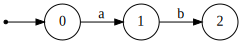

In [ ]:
map = {0: {28708: 1}, 1: {28726: 2}, 2: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = set()
fsm.initial_state = 0
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

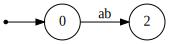

In [ ]:
fsm.apply_merge_distinct(28708, 28726, 375)
fsm.get_dfa().show_diagram()

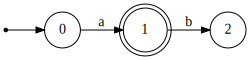

In [ ]:
map = {0: {28708: 1}, 1: {28726: 2}, 2: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = set([1])
fsm.initial_state = 0
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

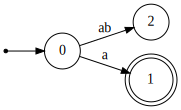

In [ ]:
fsm.apply_merge_distinct(28708, 28726, 375)
fsm.get_dfa().show_diagram()

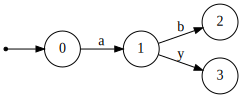

In [ ]:
map = {0: {28708: 1}, 1: {28726: 2, 28724: 3}, 3: {}, 2: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = set()
fsm.initial_state = 0
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

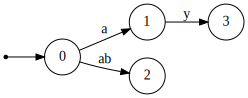

In [ ]:
fsm.apply_merge_distinct(28708, 28726, 375)
fsm.get_dfa().show_diagram()

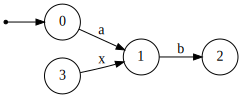

In [ ]:
map = {0: {28708: 1}, 1: {28726: 2}, 3: {28744: 1}, 2: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = set()
fsm.initial_state = 0
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

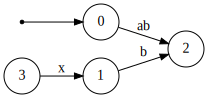

In [ ]:
fsm.apply_merge_distinct(28708, 28726, 375)
fsm.get_dfa().show_diagram()

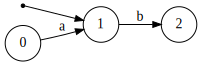

In [ ]:
map = {0: {28708: 1}, 1: {28726: 2}, 2: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = set()
fsm.initial_state = 1
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

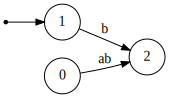

In [ ]:
fsm.apply_merge_distinct(28708, 28726, 375)
fsm.get_dfa().show_diagram()

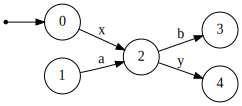

In [ ]:
map = {0: {28744: 2}, 1: {28708: 2}, 2: {28726: 3, 28724: 4}, 3: {}, 4: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = set()
fsm.initial_state = 0
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

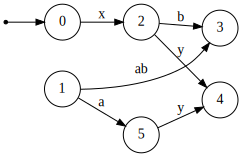

In [ ]:
fsm.apply_merge_distinct(28708, 28726, 375)
fsm.get_dfa().show_diagram()

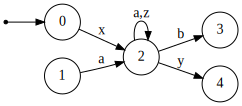

In [ ]:
map = {0: {28744: 2}, 1: {28708: 2}, 2: {28726: 3, 28724: 4, 28708: 2, 28764: 2}, 3: {}, 4: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = {}
fsm.initial_state = 0
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

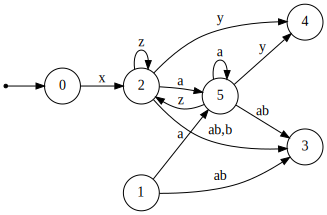

In [ ]:
fsm.apply_merge_distinct(28708, 28726, 375)
fsm.get_dfa().show_diagram()

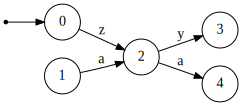

In [ ]:
map = {0: {28764: 2}, 1: {28708: 2}, 2: {28708: 4, 28724: 3}, 3: {}, 4: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = set()
fsm.initial_state = 0
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

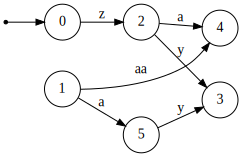

In [ ]:
fsm.apply_merge_same(28708, tokenizer.backend_tokenizer.model.token_to_id("aa"))
fsm.get_dfa().show_diagram()

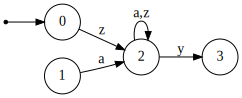

In [ ]:
map = {0: {28764: 2}, 1: {28708: 2}, 2: {28708: 2, 28764: 2, 28724: 3}, 3: {}}
fsm = DirectMergeFSM(interegular.parse_pattern("abcd").to_fsm(), string.printable, tokenizer)
fsm.map = map
fsm.final_states = set()
fsm.initial_state = 0
fsm.build_internal_variables()
fsm.get_dfa().show_diagram()

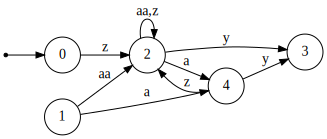

In [ ]:
fsm.apply_merge_same(28708, tokenizer.backend_tokenizer.model.token_to_id("aa"))
fsm.get_dfa().show_diagram()

# `CartesianMerge`

## Implementation: DirectMerge applied to `".*"`

Cf. Algorithm 3 of the technical appendix.

In [ ]:
class ReversibleDict(dict):
    """
    Subclass of dict that automatically maintains the inverse dictionary
    """
    def __init__(self, *args, **kwargs):
        """
        Initialize the reversible dict.
        """
        self.update(*args, **kwargs)
        self.inverse_dictionary = {}
        for key in self:
            val = self[key]
            if val in self.inverse_dictionary:
                self.inverse_dictionary[val].add(key)
            else:
                self.inverse_dictionary[val] = set([key])

    def __setitem__(self, key, val):
        """
        Set an item in the reversible dict.
        """
        if key in self:
            previous_val = self[key]
            self.inverse_dictionary[previous_val].remove(key)
        super(ReversibleDict, self).__setitem__(key, val)
        if val in self.inverse_dictionary:
            self.inverse_dictionary[val].add(key)
        else:
            self.inverse_dictionary[val] = set([key])

    def __delitem__(self, key):
        """
        Remove an item from the reversible dict.
        """
        if key in self:
            val = self[key]
            super(ReversibleDict, self).__delitem__(key)
            if val in self.inverse_dictionary:
                self.inverse_dictionary[val].remove(key)

    def get_preimage(self, val):
        """
        Get the set of the keys with a certain value.
        """
        if val in self.inverse_dictionary:
            return self.inverse_dictionary[val]
        else:
            return set()

class TokenizerFSM():
    """
    Object to create and build the DFA for `".*"` with DirectMerge.
    """
    def __init__(self, initial_token_ids, tokenizer, merge_table):
        """
        Initialize the DFA.
        """
        self.id2state = ReversibleDict({k: 0 for k in initial_token_ids})
        self.state2forbidden = {0: set()}
        self.apply_merges(tokenizer, merge_table)

    def apply_merge(self, id1, id2, id_merged):
        """
        Implement DirectMerge for a merge operation.
        """
        try:
            state1, state2 = self.id2state[id1], self.id2state[id2]
        except:
            return
        if id2 in self.state2forbidden[state1]:
            return

        if state1 == 0 or len(self.id2state.get_preimage(state1)) > 1 or id1 == id2:
            N = len(self.state2forbidden)
            self.id2state[id1] = N
            self.state2forbidden[N], state1 = set(self.state2forbidden[state1]), N
            for t in self.state2forbidden[N]:
                self.forbidden2states[t].add(N)
        self.state2forbidden[state1].add(id2)
        self.forbidden2states[id2].add(state1)

        self.id2state[id_merged] = state2
        for s in self.forbidden2states[id1]:
            self.state2forbidden[s].add(id_merged)
            self.forbidden2states[id_merged].add(s)

    def apply_merges(self, tokenizer, merge_table):
        """
        Iteratively apply DirectMerge for all merge operations of the merge table.
        """
        self.forbidden2states = defaultdict(set)
        for m in merge_table:
            token1, token2 = m.split(" ")
            id1 = get_token_id(token1, tokenizer)
            id2 = get_token_id(token2, tokenizer)
            id_merged = get_token_id(token1 + token2, tokenizer)
            assert id1 is not None and id2 is not None and id_merged is not None
            self.apply_merge(id1, id2, id_merged)
        del self.forbidden2states
        self.fuse_equivalent_states()

    def fuse_equivalent_states(self):
        """
        Fuse states with the same list of forbidden tokens.
        """
        forbidden2current_states = defaultdict(set)
        for s in self.state2forbidden:
            forbidden = self.state2forbidden[s]
            forbidden2current_states["-".join(sorted([str(x) for x in forbidden]))].add(s)

        current_state2new_state, i = {}, 0
        for f in forbidden2current_states:
            for s in forbidden2current_states[f]:
                current_state2new_state[s] = i
            i += 1

        assert current_state2new_state[0] == 0
        self.id2state = {
            t: current_state2new_state[self.id2state[t]]
            for t in self.id2state
        }
        new_state2forbidden = {}
        for s in self.state2forbidden:
            new_state = current_state2new_state[s]
            if new_state not in new_state2forbidden:
                new_state2forbidden[new_state] = self.state2forbidden[s]
        self.state2forbidden = new_state2forbidden

def get_dfa_from_tokenizer_fsm(tokenizer_fsm):
    """
    Return the corresponding DFA in view of displaying it.
    """
    states = {x for x in tokenizer_fsm.state2forbidden}
    input_symbols = {
        get_token(x, tokenizer)
        for x in tokenizer_fsm.id2state
    }
    transitions = {}
    for s in tokenizer_fsm.state2forbidden:
        transitions[s] = {
            get_token(x, tokenizer): tokenizer_fsm.id2state[x]
            for x in tokenizer_fsm.id2state
            if x not in tokenizer_fsm.state2forbidden[s]
        }
    initial_state = min([(s, len(tokenizer_fsm.state2forbidden[s])) for s in tokenizer_fsm.state2forbidden], key=lambda x: x[1])[0]
    return DFA(
        states=states,
        input_symbols=input_symbols,
        transitions=transitions,
        initial_state=initial_state,
        final_states=states,
        allow_partial=True
    )

## Implementation: brute-force method

Cf. Algorithm 4 of the technical appendix

In [ ]:
class BruteForceTokenizerFSM():
    """
    Object to create and build the DFA for `".*"` with a brute force approach.
    """
    def __init__(self, letters, tokenizer):
        self.id2state = {}
        self.state2forbidden = {}

        restricted_vocabulary = set()
        for w in tokenizer.vocab:
            for c in w:
                if c not in letters:
                    break
            else:
                restricted_vocabulary.add(get_token_id(w, tokenizer))

        # We test a token and another token are decoded and encoded in the same
        # pair. If not, the second token is disallowed for the first token.
        state2tokens = defaultdict(set)
        for token_id1 in restricted_vocabulary:
            forbidden = []
            token1 = get_token(token_id1, tokenizer)
            for token_id2 in restricted_vocabulary:
                token2 = get_token(token_id2, tokenizer)
                merged = token1 + token2
                decoded_encoded = [
                    x.as_tuple()[0]
                    for x in tokenizer.backend_tokenizer.model.tokenize(merged)
                ]
                if len(decoded_encoded) != 2:
                    forbidden.append(str(token_id2))
                else:
                    x, y = decoded_encoded
                    if x != token_id1 or y != token_id2:
                        forbidden.append(str(token_id2))
            state2tokens["-".join(sorted(forbidden))].add(token_id1)

        # We put together the tokens whose disallowed tokens are the same.
        i = 0
        for f in state2tokens:
            if len(f) > 0:
                self.state2forbidden[i] = set([int(x) for x in f.split("-")])
            else:
                self.state2forbidden[i] = set()
            for token_id in state2tokens[f]:
                self.id2state[token_id] = i
            i += 1

## Test: toy examples

We test DirectMerge applied to `".*"` (or more precisely here `"[a-c]*"`) with a basic merge table.

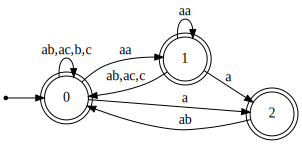

In [ ]:
from automata.fa.dfa import DFA

letters = set("abc")
tokenizer_fsm = TokenizerFSM(
    [get_token_id(c, tokenizer) for c in letters],
    tokenizer,
    ["a b", "a a", "a c"]
)

get_dfa_from_tokenizer_fsm(tokenizer_fsm).show_diagram()

We test DirectMerge applied to `".*"` (or more precisely here `"a*"`), as well as the brute force approach, with the whole merge table of the Mistral-7b tokenizer and we check that they provide the same result.

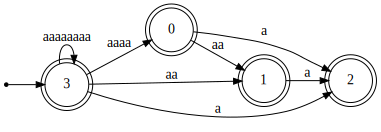

In [ ]:
letters = set("a")

brute_force_tokenizer_fsm = BruteForceTokenizerFSM(letters, tokenizer)
get_dfa_from_tokenizer_fsm(brute_force_tokenizer_fsm).show_diagram()

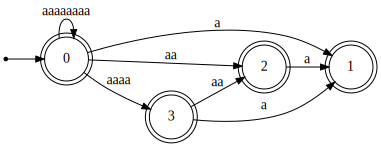

In [ ]:
tokenizer_fsm = TokenizerFSM(
    [get_token_id(c, tokenizer) for c in letters],
    tokenizer,
    tokenizer_dict["model"]["merges"]
)
get_dfa_from_tokenizer_fsm(tokenizer_fsm).show_diagram()

In [ ]:
def raise_error_if_dissimilar(tokenizer_fsm1, tokenizer_fsm2):
    """
    Compare two DFAs (in the specific format returned by Algorithm 3) and check that they are isomorphic.
    """
    assert tuple(sorted(tokenizer_fsm1.id2state.keys())) == tuple(sorted(tokenizer_fsm2.id2state.keys()))
    for token_id in tokenizer_fsm1.id2state:
        forbidden1 = tokenizer_fsm1.state2forbidden[
            tokenizer_fsm1.id2state[token_id]
        ]
        forbidden2 = tokenizer_fsm2.state2forbidden[
            tokenizer_fsm2.id2state[token_id]
        ]
        assert tuple(sorted(forbidden1)) == tuple(sorted(forbidden2))

raise_error_if_dissimilar(tokenizer_fsm, brute_force_tokenizer_fsm)

We test DirectMerge applied to the first `n` letters of the alphabet and the blank space, as well as the brute force approach, with the whole merge table of the Mistral-7b tokenizer and we check that they provide the same result. We also measure the execution time.

In [ ]:
if "toy_example_brute_force.json" in os.listdir():
    with open("toy_example_brute_force.json", "r") as f:
        toy_example_brute_force = json.load(f)
else:
    toy_example_brute_force = {}
    for i in range(1, 27):
        letters = set("▁abcdefghijklmnopqrstuvwxyz"[:i+1])

        start = time.time()
        brute_force_tokenizer_fsm = BruteForceTokenizerFSM(letters, tokenizer)
        toy_example_brute_force[str(i)] = time.time() - start

        tokenizer_fsm = TokenizerFSM(
            [get_token_id(c, tokenizer) for c in letters],
            tokenizer,
            tokenizer_dict["model"]["merges"]
        )

        raise_error_if_dissimilar(tokenizer_fsm, brute_force_tokenizer_fsm)
    with open("toy_example_brute_force.json", "w") as f:
        json.dump(toy_example_brute_force, f)

In [ ]:
if "toy_example_fsm.json" in os.listdir():
    with open("toy_example_fsm.json", "r") as f:
        toy_example_fsm = json.load(f)
else:
    toy_example_fsm = {}
    for i in range(1, 53):
        letters = set("▁abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"[:i+1])
        start = time.time()
        tokenizer_fsm = TokenizerFSM(
            [get_token_id(c, tokenizer) for c in letters],
            tokenizer,
            tokenizer_dict["model"]["merges"]
        )
        toy_example_fsm[str(i)] = {"delay": time.time() - start}
        toy_example_fsm[str(i)]["num_states"] = len(tokenizer_fsm.state2forbidden)
        toy_example_fsm[str(i)]["num_tokens"] = len(tokenizer_fsm.id2state)
    with open("toy_example_fsm.json", "w") as f:
        json.dump(toy_example_fsm, f)

As expected, the brute force approach is much less scalable than `DirectMerge`.

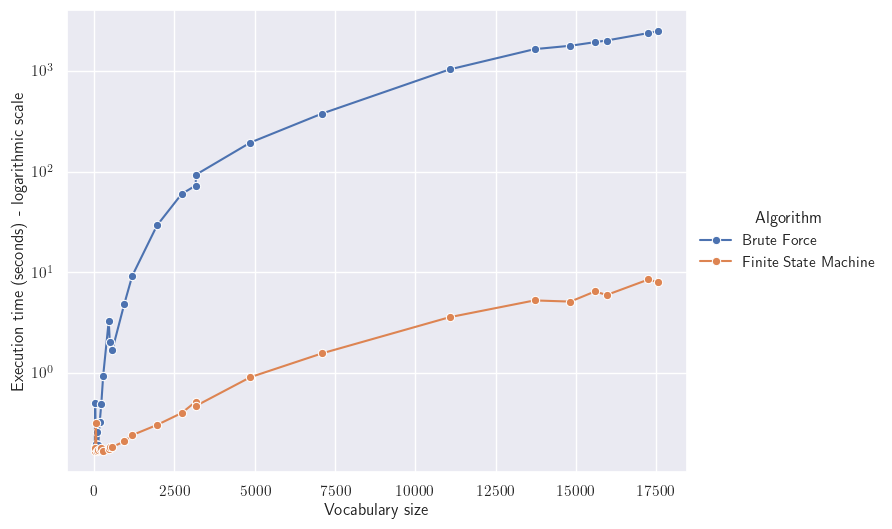

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = {"delay": [], "Algorithm": [], "num_tokens": []}
for i in range(1, 27):
    results["delay"].append(toy_example_brute_force[str(i)])
    results["num_tokens"].append(toy_example_fsm[str(i)]["num_tokens"])
    results["Algorithm"].append("Brute Force")
    results["delay"].append(toy_example_fsm[str(i)]["delay"])
    results["num_tokens"].append(toy_example_fsm[str(i)]["num_tokens"])
    results["Algorithm"].append("Finite State Machine")

df = pd.DataFrame.from_dict(results)
g = sns.lineplot(data=df, x="num_tokens", y="delay", hue="Algorithm", marker="o")
sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), frameon=False)
plt.yscale('log')
plt.ylabel("Execution time (seconds) - logarithmic scale")
_ = plt.xlabel("Vocabulary size")

## Test: random walk

To further test `DirectMerge` applied to the `".*"` case, we perform a random walk. At each time step, we check that a disallowed token leads to an improper token sequence. We select an allowed token and check that this leads to a proper token sequence.

In [ ]:
%%time
import numpy as np

letters = set("▁abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
tokenizer_fsm = TokenizerFSM(
    [get_token_id(c, tokenizer) for c in letters],
    tokenizer,
    tokenizer_dict["model"]["merges"]
)

all_tokens = tokenizer_fsm.id2state.keys()

for _ in range(10):
    token_seq = [np.random.choice(list(all_tokens))]
    text_seq = [get_token(token_seq[-1], tokenizer)]
    for _ in range(10):
        forbidden = tokenizer_fsm.state2forbidden[tokenizer_fsm.id2state[token_seq[-1]]]
        if len(forbidden) > 0:
            bad_id = np.random.choice(list(forbidden))
            bad_text = get_token(bad_id, tokenizer)
            merged = "".join(text_seq + [bad_text])
            decoded_encoded = [
                x.as_tuple()[0]
                for x in tokenizer.backend_tokenizer.model.tokenize(merged)
            ]
            assert tuple(token_seq + [bad_id]) != tuple(decoded_encoded)

        good_id = np.random.choice([x for x in all_tokens if x not in forbidden])
        good_text = get_token(good_id, tokenizer)
        merged = "".join(text_seq + [good_text])
        decoded_encoded = [
            x.as_tuple()[0]
            for x in tokenizer.backend_tokenizer.model.tokenize(merged)
        ]
        token_seq.append(good_id)
        text_seq.append(good_text)
        assert tuple(token_seq) == tuple(decoded_encoded)

CPU times: user 12.6 s, sys: 750 ms, total: 13.4 s
Wall time: 19 s


## Test: tokenizer FSM with the whole tokenizer vocabulary

We measure the time required to build the `".*"` DFA for the Mistral-7b tokenizer. It takes approximately 20 seconds.

In [ ]:
%%time
merged = {s.replace(" ", "") for s in tokenizer_dict["model"]["merges"]}
initial_ids = {
    tokenizer.backend_tokenizer.model.token_to_id(k)
    for k in tokenizer.vocab
    if k not in merged
}
tokenizer_fsm = TokenizerFSM(
    initial_ids,
    tokenizer,
    tokenizer_dict["model"]["merges"]
)

CPU times: user 12.8 s, sys: 514 ms, total: 13.3 s
Wall time: 17.7 s


The number of disallowed tokens varies between 0 and 12260.

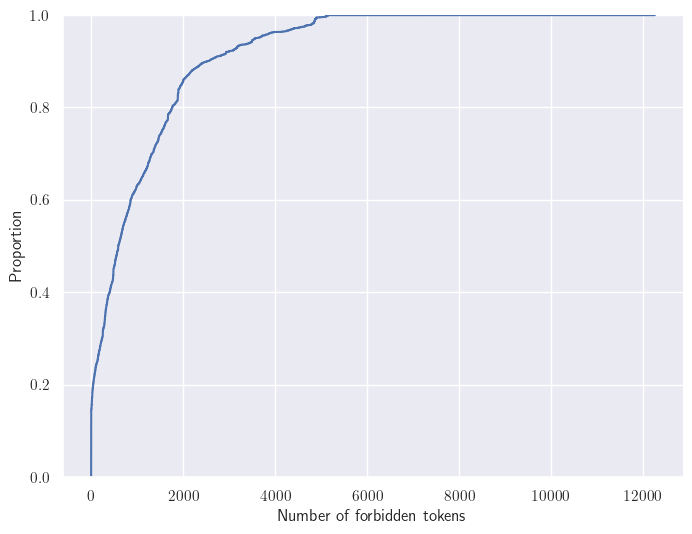

In [ ]:
result = [
    len(tokenizer_fsm.state2forbidden[tokenizer_fsm.id2state[i]])
    for i in range(len(tokenizer.vocab))
]
sns.ecdfplot(
    data=pd.DataFrame.from_dict(
        {"Number of forbidden tokens": result}
    ),
    x="Number of forbidden tokens"
)
sns.despine()

We show some examples of tokens with the lowest and highest numbers of disallowed tokens.

In [ ]:
sorted_tokens = sorted(
    [
        (
            i,
            get_token(i, tokenizer),
            len(tokenizer_fsm.state2forbidden[tokenizer_fsm.id2state[i]])
        )
        for i in range(32000)
    ],
    key=lambda x: x[2]
)
sorted_tokens[:5], sorted_tokens[-5:]

([(0, '<unk>', 0),
  (1, '<s>', 0),
  (2, '</s>', 0),
  (3, '<0x00>', 0),
  (4, '<0x01>', 0)],
 [(2287, '▁▁▁', 12260),
  (2600, '▁▁▁▁▁▁▁▁▁', 12260),
  (5390, '▁▁▁▁▁▁▁', 12260),
  (17422, '▁▁▁▁▁▁▁▁▁▁▁', 12260),
  (28705, '▁', 12260)])

## Test: books

We test over two long books that their tokenized content is recognized as a proper token sequence (no false negatives).

In [ ]:
%%capture
!wget -nc https://www.gutenberg.org/cache/epub/2814/pg2814.txt # Dubliners, by James Joyce (English)
!wget -nc https://www.gutenberg.org/cache/epub/19657/pg19657.txt # Notre Dame de Paris, by Victor Hugo (French)

In [ ]:
%%time
for filename in ["pg2814.txt", "pg19657.txt"]:
    with open(filename, "r") as f:
        s = f.read()
    encoded = tokenizer.encode(s)
    for i in range(len(encoded) - 1):
        token1, token2 = encoded[i], encoded[i+1]
        assert token2 not in tokenizer_fsm.state2forbidden[tokenizer_fsm.id2state[token1]]

CPU times: user 1.72 s, sys: 152 ms, total: 1.87 s
Wall time: 2.44 s


## Implementation: identification of relevant product states

As part of Algorithm 5 of the technical appendix, we look for the relevant product states (i.e. on a path between the start product state and an accept product state).

In [ ]:
from outlines.fsm.fsm import RegexFSM

class NormalizedRegexFSM(RegexFSM):

    def normalize(self, tokenizer_fsm):
        """
        Remove out-of-vocabulary tokens (ie. not covered by the Tokenizer FSM).
        Remove EOS token id and -1 state.
        Initialize self.initial_state.
        """
        to_remove, to_add = set(), set()
        self.final_states = {s for s in self.final_states if s != -1}
        for s1 in self.states_to_token_maps:
            for token in self.states_to_token_maps[s1]:
                if token == self.end_token_id or token not in tokenizer_fsm.id2state:
                    to_remove.add((s1, token))
                else:
                    s2 = self.states_to_token_maps[s1][token]
                    if s2 not in self.states_to_token_maps:
                        to_add.add(s2)
        for s, token in to_remove:
            del self.states_to_token_maps[s][token]
        for s in to_add:
            self.states_to_token_maps[s] = {}
        self.initial_state = 0

In [ ]:
from numba import jit, types, typed

@jit(nopython=True)
def create_dict(items):
    """
    Convert a dict into a typed dict.
    """
    return {k: v for k,v in items}

def dict_to_items(d):
    """
    Return a typed list of the items of a dict.
    """
    if len(d) > 0:
        return typed.List(d.items())
    else:
        return typed.List.empty_list(types.Tuple((types.int64, types.int64)))

def convert_dict_dict(d):
    """
    Convert a dict of dict into its typed equivalent.
    """
    d2 = {k: create_dict(dict_to_items(d[k])) for k in d}
    return create_dict(dict_to_items(d2))

def get_dict_from_tokenizer_fsm(tokenizer_fsm):
    """
    Convert the internal variables of a DFA resulting from Algorithm 3 into their typed equivalents.
    """
    id2state = typed.Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
    )
    for k in tokenizer_fsm.id2state:
        id2state[k] = tokenizer_fsm.id2state[k]

    state2forbidden = typed.Dict.empty(
        key_type=types.int64,
        value_type=types.DictType(types.int64, types.boolean),
    )
    for k in tokenizer_fsm.state2forbidden:
        v = typed.Dict.empty(
            key_type=types.int64,
            value_type=types.boolean,
        )
        for t in tokenizer_fsm.state2forbidden[k]:
            v[t] = True
        state2forbidden[k] = v
    return id2state, state2forbidden

key_type = types.UniTuple(types.int64, 2)
value_type = types.DictType(types.int64, types.boolean)

@jit(
    types.DictType(types.int64, types.DictType(types.int64, types.UniTuple(types.int64, 2)))
    (
        types.DictType(types.int64, types.DictType(types.int64, types.int64)),
        types.DictType(types.int64, types.int64),
        types.DictType(types.int64, types.DictType(types.int64, types.boolean)),
        types.ListType(types.int64)
    ),
    nopython=True
)
def get_possible_composite_states(
        states_to_token_maps,
        id2state,
        state2forbidden,
        final_states
    ):
    """
    Find relevant composite states with a breadth-first exploration
    """
    # Since it doesn't seem possible to create dicts with sets as values in
    # Numba, I replaced them with dicts having int2boolean dicts as values
    map: types.DictType(types.int64, types.DictType(types.Tuple((types.int64, types.int64)), types.DictType(types.int64, types.boolean))) = {}
    new_map: types.DictType(types.int64, types.DictType(types.int64, types.Tuple((types.int64, types.int64)))) = {}
    inverse_map: types.DictType(types.int64, types.DictType(types.int64, types.boolean)) = {}
    predecessors: types.DictType(types.Tuple((types.int64, types.int64)), types.Tuple((types.int64, types.int64))) = {}

    # We create a copy of the transition map of the regex DFA but we group the
    # transitions according to the target states of both DFA (the regex DFA and
    # the  tokenizer DFA). In this way, when exploring, we can test transitions
    # in these groups and when we have a match, we can directly move on to the
    # next group without further testing the transitions in the current group.
    for s in states_to_token_maps:
        map[s] = typed.Dict.empty(
            key_type=key_type,
            value_type=value_type
        )
        for t in states_to_token_maps[s]:
            tokenizer_state = id2state[t]
            s2 = states_to_token_maps[s][t]
            if (s2, tokenizer_state) not in map[s]:
                map[s][(s2, tokenizer_state)] = {t: True}
            else:
                map[s][(s2, tokenizer_state)][t] = True
            if s2 not in inverse_map:
                inverse_map[s2] = {s: True}
            else:
                inverse_map[s2][s] = True

    # We start from the composite state made of both start states
    to_explore = [(0, 0)]

    # We store the reachable composite states in a dict. 1st key: state of the
    # regex DFA, 2nd key: state of the tokenizer DFA.
    reachable = {0: {0: True}}

    i, n = 0, 1
    # We perform a breadth-first exploration to find the reachable states.
    while i < n:
        regex_state, tokenizer_state = to_explore[i]
        i += 1
        for (regex_state2, tokenizer_state2) in map[regex_state]:
            if regex_state2 not in reachable or tokenizer_state2 not in reachable[regex_state2]:
                for t in map[regex_state][(regex_state2, tokenizer_state2)]:
                    if t > 2 and t not in state2forbidden[tokenizer_state]:
                        predecessors[(regex_state2, tokenizer_state2)] = (regex_state, tokenizer_state)
                        if regex_state2 not in reachable:
                            reachable[regex_state2] = {tokenizer_state2: True}
                        else:
                            reachable[regex_state2][tokenizer_state2] = True
                        to_explore.append((regex_state2, tokenizer_state2))
                        n += 1
                        break

    # We store the relevant composite states in a dict (relevant = on a path
    # between the start state and an accept state). 1st key: state of the regex
    # DFA, 2nd key: state of the tokenizer DFA.
    final_reachable = {0: {0: True}}
    for s in final_states:
        for tokenizer_state in reachable[s]:
            if s not in final_reachable:
                final_reachable[s] = {tokenizer_state: True}
            else:
                final_reachable[s][tokenizer_state] = True

    # For the exploration, we start from all reachable accept states.
    to_explore: types.ListType(types.Tuple((types.int64, types.int64))) = []
    for regex_state in final_reachable:
        for tokenizer_state in final_reachable[regex_state]:
            to_explore.append((regex_state, tokenizer_state))

    # We also add predecessors leading to these reachable accept states.
    i, n = 0, len(to_explore)
    while i < n:
        regex_state, tokenizer_state = to_explore[i]
        i += 1
        if (regex_state, tokenizer_state) in predecessors:
            predecessor = predecessors[(regex_state, tokenizer_state)]
            if tokenizer_state not in final_reachable[regex_state]:
                n += 1
                if regex_state not in final_reachable:
                    final_reachable[regex_state] = {tokenizer_state: True}
                else:
                    final_reachable[regex_state][tokenizer_state] = True
                to_explore.append(predecessor)

    to_explore: types.ListType(types.Tuple((types.int64, types.int64))) = []
    for regex_state in final_reachable:
        for tokenizer_state in final_reachable[regex_state]:
            to_explore.append((regex_state, tokenizer_state))

    # Starting from an initial list of relevant composite states, we go through
    # their potential predecessors and check that they are indeed predecessors.
    # If so, we add them to the list of composite states to explore. We do so
    # until there are no more composite states to explore.
    i, n = 0, len(to_explore)
    while i < n:
        regex_state2, tokenizer_state2 = to_explore[i]
        i += 1
        if regex_state2 in inverse_map:
            for regex_state in inverse_map[regex_state2]:
                if (regex_state2, tokenizer_state2) in map[regex_state]:
                    for t in map[regex_state][(regex_state2, tokenizer_state2)]:
                        for tokenizer_state in reachable[regex_state]:
                            if regex_state not in final_reachable or tokenizer_state not in final_reachable[regex_state]:
                                if t not in state2forbidden[tokenizer_state]:
                                    if regex_state not in final_reachable:
                                        final_reachable[regex_state] = {tokenizer_state: True}
                                    else:
                                        final_reachable[regex_state][tokenizer_state] = True
                                    to_explore.append((regex_state, tokenizer_state))
                                    n += 1
                                    if len(final_reachable[regex_state]) == len(reachable[regex_state]):
                                        break

    for s in map:
        new_map[s] = typed.Dict.empty(
            key_type=types.int64,
            value_type=key_type
        )
        for (regex_state2, tokenizer_state2) in map[s]:
            if regex_state2 in final_reachable:
                if tokenizer_state2 in final_reachable[regex_state2]:
                    for t in map[s][(regex_state2, tokenizer_state2)]:
                        new_map[s][t] = (regex_state2, tokenizer_state2)

    return new_map

## Example: comparison of Outlines and DirectMerge on a simple example

We generate the DFAs presented in the second section of the blog post.

In [ ]:
def get_dfa_from_outlines_fsm(regex_fsm):
    """
    Return the corresponding DFA in view of displaying it.
    """
    states = set(regex_fsm.states_to_token_maps.keys())
    final_states = set()
    for s in regex_fsm.final_states:
        if s != -1:
            states.add(s)
            final_states.add(s)
    input_symbols = set()
    transitions = {}
    for s in states:
        transitions[s] = {}
        if s in regex_fsm.states_to_token_maps:
            for x in regex_fsm.states_to_token_maps[s]:
                token = get_token(x, tokenizer)
                input_symbols.add(token)
                transitions[s][token] = regex_fsm.states_to_token_maps[s][x]
    initial_state = 0
    return DFA(
        states=states,
        input_symbols=input_symbols,
        transitions=transitions,
        initial_state=initial_state,
        final_states=final_states,
        allow_partial=True
    )

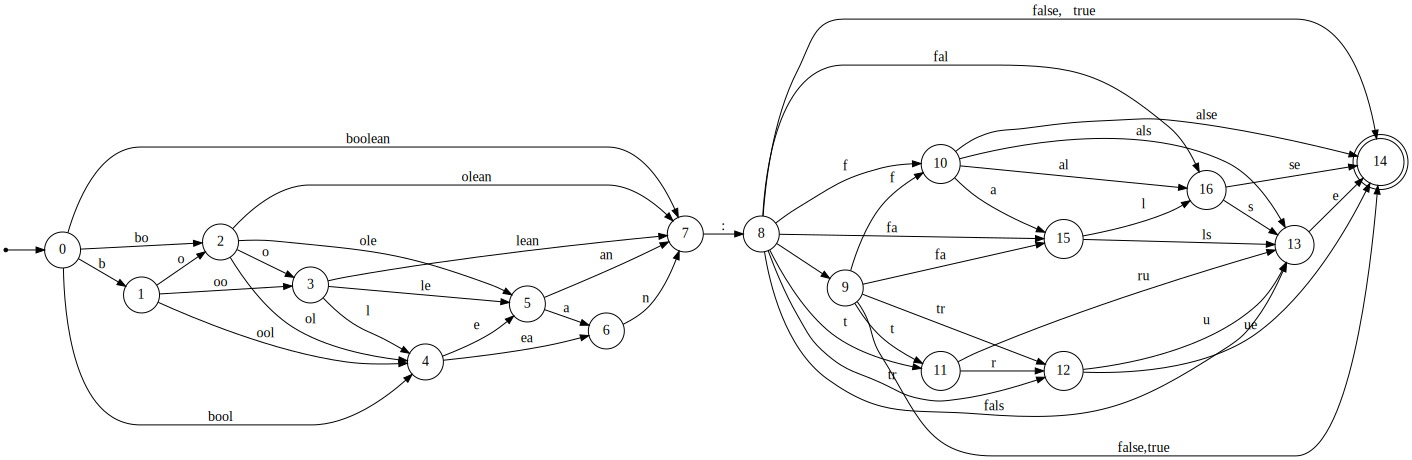

In [ ]:
get_dfa_from_outlines_fsm(regex_fsm).show_diagram()

In [ ]:
# Number of transitions
sum([len(regex_fsm.states_to_token_maps[s]) for s in regex_fsm.states_to_token_maps])

48

/usr/local/lib/python3.10/dist-packages/outlines/fsm/regex.py:474: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'fsm_finals' of function '_walk_fsm'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../usr/local/lib/python3.10/dist-packages/outlines/fsm/regex.py", line 226:
@numba.njit(nogil=True, cache=True)
def _walk_fsm(
^

  state_seq = _walk_fsm(
/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'fsm_finals' of function 'state_scan_tokens'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../usr/local/lib/python3.10/dis

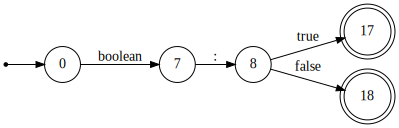

In [ ]:
fsm = DirectMergeFSM(interegular.parse_pattern("boolean: ((true)|(false))").to_fsm(), string.printable, tokenizer)
fsm.apply_merges(tokenizer_dict["model"]["merges"])
letters = [c for c in string.printable if c != "\n"]
tokenizer_fsm = TokenizerFSM(
    [encode(c, tokenizer)[0] for c in letters],
    tokenizer,
    tokenizer_dict["model"]["merges"]
)
regex_fsm = NormalizedRegexFSM("boolean: ((true)|(false))", tokenizer_outlines)
regex_fsm.normalize(tokenizer_fsm)
fsm.get_dfa().show_diagram()

## Test: comparison of `CartesianMerge` and `DirectMerge`

We check that `CartesianMerge` and `DirectMerge` return the same result (up to an isomorphism).

In [ ]:
letters = [c for c in string.printable if c != "\n"]
tokenizer_fsm = TokenizerFSM(
    [encode(c, tokenizer)[0] for c in letters],
    tokenizer,
    tokenizer_dict["model"]["merges"]
)
id2state, state2forbidden = get_dict_from_tokenizer_fsm(tokenizer_fsm)

In [ ]:
def get_dfa_cartesian(regex_fsm, tokenizer_fsm, new_map):
    """
    Create the DFA implicitly built by `CartesianMerge`. In general, explicitly
    generating this DFA is too computationally expensive. This should be done
    only with toy examples.
    """
    states = set()
    initial_state = "-".join(str(x) for x in (regex_fsm.initial_state, 0))
    final_states = set()
    states.add(initial_state)
    for s in new_map:
        for t in new_map[s]:
            states.add("-".join(str(x) for x in new_map[s][t]))

    transitions = {}
    input_symbols = set()
    for s in states:
        transitions[s] = {}
        regex_state, tokenizer_state = [int(x) for x in s.split("-")]
        if regex_state in regex_fsm.final_states:
            final_states.add(s)
        for t in new_map[regex_state]:
            token = get_token(t, tokenizer)
            input_symbols.add(token)
            if t not in state2forbidden[tokenizer_state]:
                transitions[s][token] = "-".join(str(x) for x in new_map[regex_state][t])

    return DFA(
        states=states,
        input_symbols=input_symbols,
        transitions=transitions,
        initial_state="0-0",
        final_states=final_states,
        allow_partial=True
    )

In [ ]:
def check_pattern(pattern):
    """
    Check whether the direct merge table approach and the cartesian product approach yield the same results.
    Return the common minified DFA
    """
    regex_fsm = NormalizedRegexFSM(pattern, tokenizer_outlines)
    regex_fsm.normalize(tokenizer_fsm)
    new_map = get_possible_composite_states(
        convert_dict_dict(regex_fsm.states_to_token_maps),
        id2state,
        state2forbidden,
        typed.List(regex_fsm.final_states)
    )
    dfa1 = get_dfa_cartesian(regex_fsm, tokenizer_fsm, new_map).minify()

    fsm = DirectMergeFSM(interegular.parse_pattern(pattern).to_fsm().reduce(), letters, tokenizer)
    fsm.apply_merges(tokenizer_dict["model"]["merges"])
    dfa2 = fsm.get_dfa().minify()

    assert dfa1.issubset(dfa2) and dfa2.issubset(dfa1)
    return dfa1

For the following patterns, we create the target DFA with `DirectMerge` and `CartesianMerge`, check that the results are isomorphic and display the DFA.

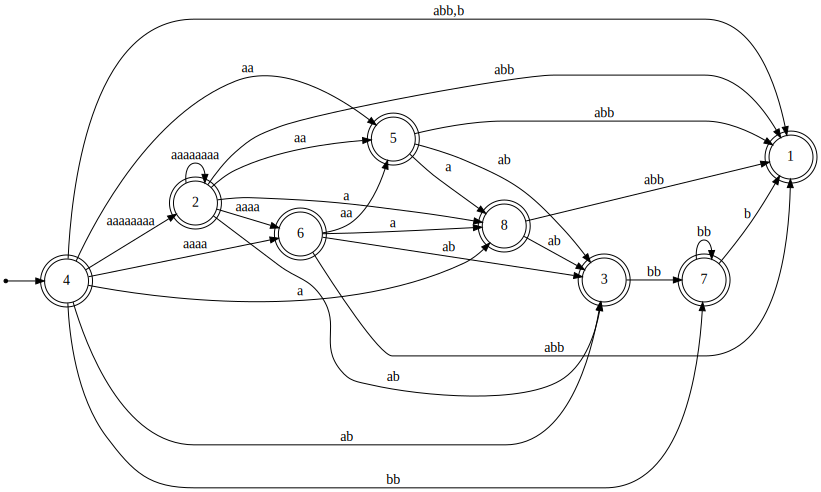

In [ ]:
pattern = "a*b*"
check_pattern(pattern).show_diagram()

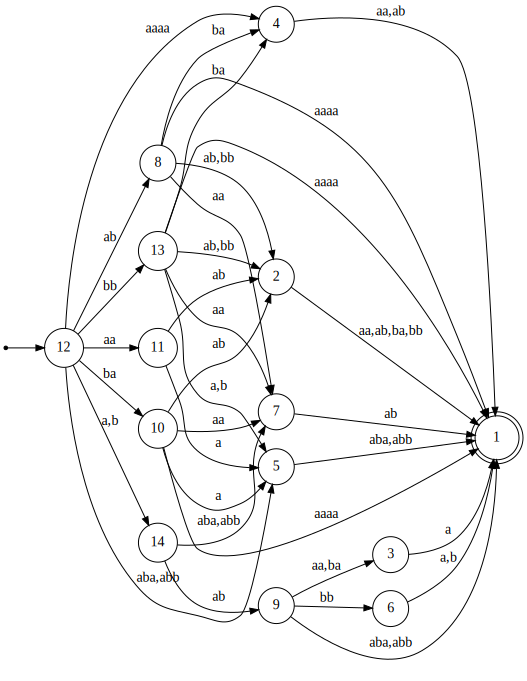

In [ ]:
pattern = "(a|b){6}"
check_pattern(pattern).show_diagram()

In [ ]:
pattern = "."
check_pattern(pattern).show_diagram()

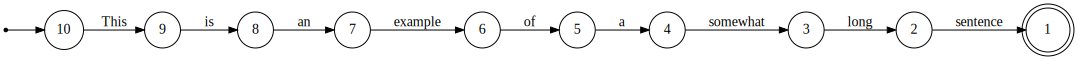

In [ ]:
pattern = "This is an example of a somewhat long sentence"
check_pattern(pattern).show_diagram()

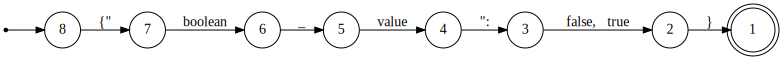

In [ ]:
pattern = r'{"boolean_value": ((false)|(true))}'
check_pattern(pattern).show_diagram()

## Scalability of DirectMerge and CartesianMerge

We compute the DFA for `"[ a-z]{i}"` with various values of `i` with both `DirectMerge` and `CartesianMerge`. We measure the number of parameters and the execution time.

In [ ]:
letters = "▁abcdefghijklmnopqrstuvwxyz"
tokenizer_fsm = TokenizerFSM(
    [encode(c, tokenizer)[0] for c in letters],
    tokenizer,
    tokenizer_dict["model"]["merges"]
)
id2state, state2forbidden = get_dict_from_tokenizer_fsm(tokenizer_fsm)

In [ ]:
def count_parameters_directmerge(fsm):
    """
    Count the number of integers required to describe the DFA created with `DirectMerge`.
    There is one integer per final state, one per state and two per transition.
    """
    return (
        len(fsm.final_states)
        + sum(2*len(fsm.map[s]) for s in fsm.map)
        + len(fsm.map)
    )

def count_parameters_tokenizer_fsm(tokenizer_fsm):
    """
    Count the number of integers required to describe the tokenizer DFA.
    There are two integers for each entry of `id2state` and one for each element of each list of forbidden tokens.
    """
    return len(tokenizer_fsm.id2state)*2 + sum(len(tokenizer_fsm.state2forbidden[s]) for s in tokenizer_fsm.state2forbidden)

def count_parameters_cartesianmerge(regex_fsm, final_reachable):
    """
    Count the number of integers required to describe the DFA created with `CartesianMerge` (excluding those for the tokenizer DFA).
    There are the integers required to describe the regex DFA and those for the list of possible composite states.
    """
    return (
        len(regex_fsm.final_states)
        + sum(2*len(regex_fsm.states_to_token_maps[s]) for s in regex_fsm.states_to_token_maps)
        + len(regex_fsm.states_to_token_maps)
    ), sum(len(final_reachable[s]) for s in final_reachable)

In [ ]:
results = {"i": [], "approach": [], "num_integers": [], "execution_time": []}

for i in range(1, 7):
    pattern = "."*i

    start = time.time()
    regex_fsm = NormalizedRegexFSM(pattern, tokenizer_outlines)
    regex_fsm.normalize(tokenizer_fsm)
    final_reachable = get_possible_composite_states(
        convert_dict_dict(regex_fsm.states_to_token_maps),
        id2state,
        state2forbidden,
        typed.List(regex_fsm.final_states)
    )
    results["execution_time"].append(time.time() - start)
    results["approach"].append("CartesianMerge")
    results["num_integers"].append(
        count_parameters_tokenizer_fsm(tokenizer_fsm)
        + sum(count_parameters_cartesianmerge(regex_fsm, final_reachable))
    )
    results["i"].append(i)

    start = time.time()
    fsm = DirectMergeFSM(interegular.parse_pattern(pattern).to_fsm(), string.printable, tokenizer)
    fsm.apply_merges(tokenizer_dict["model"]["merges"])
    results["execution_time"].append(time.time() - start)
    results["approach"].append("DirectMerge")
    results["num_integers"].append(count_parameters_directmerge(fsm))
    results["i"].append(i)

df = pd.DataFrame.from_dict(results)

We see that `CartesianMerge` is clearly more scalable than `DirectMerge`.
PS: the execution time for `CartesianMerge` does not account for generating the tokenizer DFA (which is the same for all regex and just needs to be computed once for a given tokenizer).

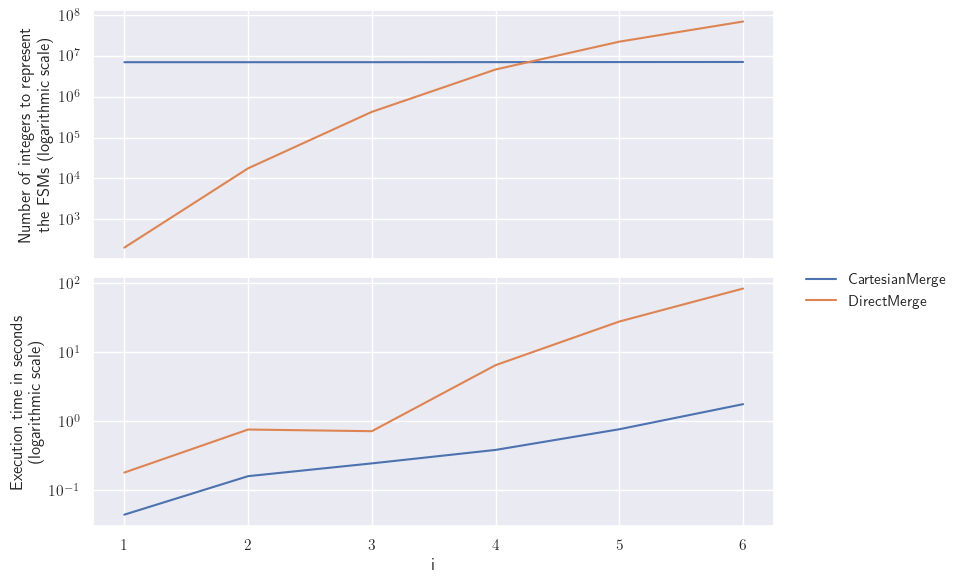

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
g = sns.lineplot(data=df, x="i", y="num_integers", color="g", hue="approach", ax=ax1)
g.set(yscale='log', ylabel='Number of integers to represent\nthe FSMs (logarithmic scale)')
g = sns.lineplot(data=df, x="i", y="execution_time", ax=ax2, hue="approach", legend=False)
g.set(yscale='log', ylabel='Execution time in seconds\n(logarithmic scale)')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
sns.move_legend(fig, "center left", bbox_to_anchor=(1, 0.5), frameon=False)
ax1.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

# Experiment: Glaive function calling dataset

We test `CartesianMerge` with the `glaive-function-calling-v2` dataset. It includes json strings with their corresponding json schemas. We check that the json strings are compatible with the DFA created with `CartesianMerge`. We also measure the execution time.

In [ ]:
from datasets import load_dataset
from outlines.fsm.json_schema import build_regex_from_object

size_vocabulary = len(tokenizer.vocab)

if "function_calling_results.json" not in os.listdir():
    i = -1
    results = defaultdict(lambda: defaultdict(list))
    n = 0
else:
    with open("function_calling_results.json", "r") as f:
        results = defaultdict(lambda: defaultdict(list), json.load(f))
    i = max([int(k) for k in results.keys()])
    n = sum(
        len(results[k]["choices_cartesian"])
        for k in results
        if k != -1
        if "choices_cartesian" in results[k]
    )

if n < 1000:
    dataset = load_dataset("glaiveai/glaive-function-calling-v2")

    # We create the tokenizer DFA.
    start = time.time()
    tokenizer_fsm = TokenizerFSM(
        [encode(c, tokenizer)[0] for c in string.printable],
        tokenizer,
        tokenizer_dict["model"]["merges"]
    )
    results[-1]["delay_tokenizer_fsm"] = time.time() - start
    id2state, state2forbidden = get_dict_from_tokenizer_fsm(tokenizer_fsm)

# For each record of the dataset...
while n < 1000:
    i += 1
    try:
        system = dataset["train"][i]["system"].split("Use them if required -\n")[1].strip()
    except IndexError:
        continue
    # We extract the json schemas corresponding to functions.
    functions = {}
    start, delta_brackets = 0, 0
    for pos in range(len(system)):
        if system[pos] == "{":
            delta_brackets += 1
        elif system[pos] == "}":
            delta_brackets -= 1
            if delta_brackets == 0:
                function = json.loads(system[start:pos+1])
                functions[function["name"]] = function["parameters"]
                start = pos + 1
    # We extract the json strings correspondning to function calls.
    function_calls = defaultdict(list)
    if "<functioncall> " in dataset["train"][i]["chat"]:
        for x in dataset["train"][i]["chat"].split("<functioncall> ")[1:]:
            try:
                function_call = json.loads(
                    x.split(" <|endoftext|>")[0]
                    .replace("\'{", "{")
                    .replace("}\'", "}")
                    .replace("\'[", "[")
                    .replace("]\'", "]")
                    .replace("\\\'", "'")
                )
                function_calls[function_call["name"]].append(function_call["arguments"])
            except:
                continue

    # For each json schema for which there is a json string...
    for name in function_calls:
        if name not in functions:
            continue
        try:
            pattern = build_regex_from_object(json.dumps(functions[name]))
        except NotImplementedError:
            continue
        results[i]["function"].append(name)
        # We build the regex DFA with outlines.
        start = time.time()
        regex_fsm = NormalizedRegexFSM(pattern, tokenizer_outlines)
        results[i]["delay_outlines"].append(time.time() - start)

        # We list the possible composite states.
        start = time.time()
        regex_fsm.normalize(tokenizer_fsm)
        new_map = get_possible_composite_states(
            convert_dict_dict(regex_fsm.states_to_token_maps),
            id2state,
            state2forbidden,
            typed.List(regex_fsm.final_states)
        )
        results[i]["delay_cartesian"].append(time.time() - start)

        # For each json string corresponding to a function call...
        for parameters in function_calls[name]:
            parameters = json.dumps(parameters)

            # We first that the string complies with the regex. It might not be
            # the case because Outlines does not fully support all JSON schema
            # features
            if re.compile(pattern).match(parameters) is None:
                continue
            n += 1
            token_sequence = encode(parameters, tokenizer)
            regex_state = regex_fsm.initial_state
            tokenizer_state = 0

            choices_outlines, choices_cartesian = [], []

            for t in token_sequence:

                # For each token, we list the allowed tokens.
                start = time.time()
                mask = np.zeros(size_vocabulary)
                mask[list(new_map[regex_state])] = 1
                mask[list(tokenizer_fsm.state2forbidden[tokenizer_state])] = 0
                results[i]["delay_decoding"].append(time.time() - start)

                # We check that the actual token is among the allowed tokens.
                assert int(mask[t]) == 1

                # We check that `CartesianMerge` is always more restrictive than
                # `Outlines`.
                choices_outlines.append(len(regex_fsm.states_to_token_maps[regex_state]))
                choices_cartesian.append(int(np.sum(mask)))
                assert choices_outlines[-1] >= choices_cartesian[-1]

                # We keep track of the states of both DFAs.
                regex_state, tokenizer_state = new_map[regex_state][t]

            results[i]["choices_outlines"].append(choices_outlines)
            results[i]["choices_cartesian"].append(choices_cartesian)

    if i % 5 == 0:
        with open("function_calling_results.json", "w") as f:
            json.dump(results, f)
            print(i, n, time.time())

In [ ]:
with open("function_calling_results.json", "r") as f:
    results = defaultdict(lambda: defaultdict(list), json.load(f))

delays_outlines = []
delays_cartesian = []
for k in results:
    if "delay_outlines" in results[k]:
        delays_outlines.extend(results[k]["delay_outlines"])
        for i in range(len(results[k]["delay_outlines"])):
            delays_cartesian.append(results[k]["delay_cartesian"][i] + results[k]["delay_outlines"][i])
df = pd.DataFrame(columns=["Method", "Preprocessing time (seconds)"])
df["Method"] = ["outlines"]*len(delays_outlines) + ["CartesianMerge"]*len(delays_cartesian)
df["Preprocessing time (seconds)"] = delays_outlines + delays_cartesian

delays_decoding = []
for i in results:
    if "delay_decoding" in results[i]:
        delays_decoding.extend(results[i]["delay_decoding"])

np.mean(delays_outlines), np.mean(delays_cartesian)-np.mean(delays_outlines), results["-1"]["delay_tokenizer_fsm"], np.mean(delays_decoding)

(0.6869955827216773,
 27.258802759074104,
 20.870391607284546,
 0.0015315119331255705)

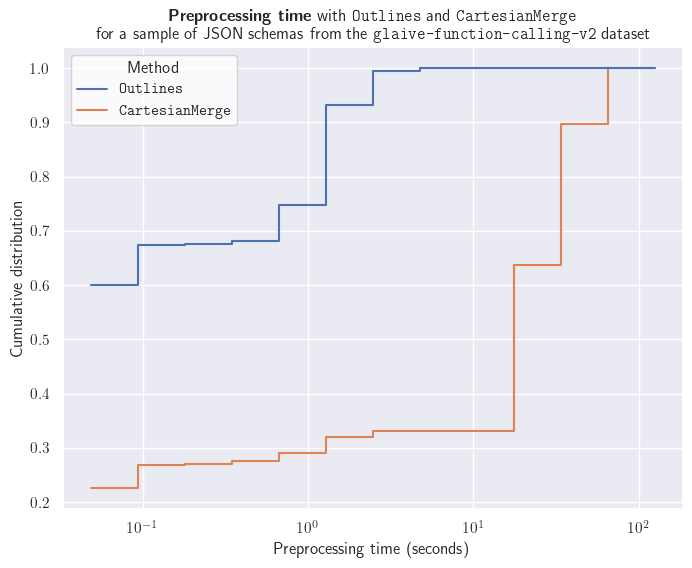

In [ ]:
sns.set_theme()
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,6)})

fig, ax = plt.subplots()
g = sns.histplot(
    data=df, x="Preprocessing time (seconds)", hue="Method",
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
    ax=ax
)

for t in g.legend_.texts:
    t.set_text(t.get_text().replace('outlines', r'$\texttt{Outlines}$').replace('CartesianMerge', r'$\texttt{CartesianMerge}$'))

g.legend_.get_frame().set_facecolor('white')

_ = g.set(title=
    r"\textbf{Preprocessing time} with "
    + r"\texttt{"
    + "Outlines} and "
    + r"\texttt{"
    + "CartesianMerge}"
    + "\nfor a sample of JSON schemas from the "
    + r"\texttt{"
    + "glaive-function-calling-v2} dataset",
    ylabel="Cumulative distribution"
)

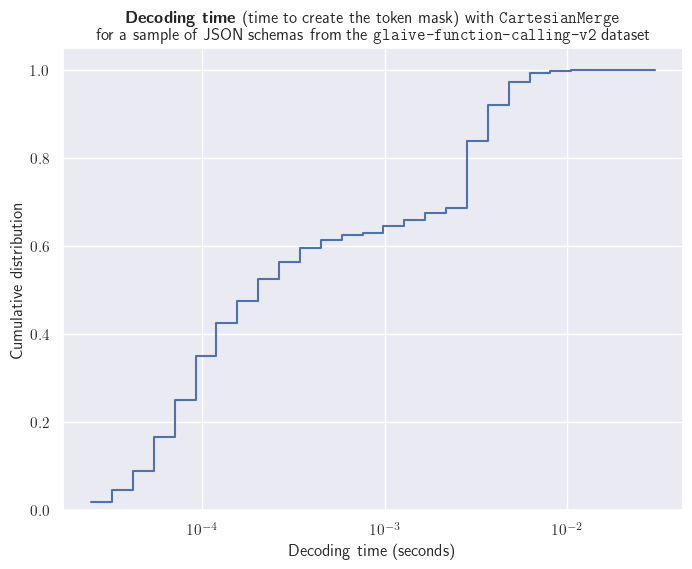

In [ ]:
fig, ax = plt.subplots()
g = sns.histplot(
    data=pd.DataFrame.from_dict({"Decoding time (seconds)": delays_decoding}),
    x="Decoding time (seconds)",
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
    ax=ax
)

_ = g.set(title=
    r"\textbf{Decoding time} (time to create the token mask) with "
    + r"\texttt{"
    + "CartesianMerge}"
    + "\nfor a sample of JSON schemas from the "
    + r"\texttt{"
    + "glaive-function-calling-v2} dataset",
    ylabel="Cumulative distribution"
)

Among the 18898 tokens seen, 3853 (resp. 750) have only one allowed token with `CartesianMerge` (`Outlines`), which means that we can skip the LLM call. This is not really an estimate of the actual fraction of LLM calls we can skip because here we assume that we align with the "ground truth" for all preceding tokens. In particular the tokens generated so far form a proper token sequence which is not necessarily the case with `Outlines`.

In [ ]:
num_tokens = 0
num_one_option_outlines = 0
num_one_option_cartesian = 0

for k in results:
    if "choices_outlines" in results[k]:
        for seq in results[k]["choices_outlines"]:
            num_tokens += len(seq)
            num_one_option_outlines += sum(1 for x in seq if x == 1)
        for seq in results[k]["choices_cartesian"]:
            num_one_option_cartesian += sum(1 for x in seq if x == 1)

print(num_tokens, num_one_option_cartesian)

18898 3853


# Example: token masking distorting the LLM distribution

This is the example in the second section of the blog post.

In [ ]:
%%capture
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel


MODEL_NAME = "Hugofernandez/Mistral-7B-v0.1-colab-sharded"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use 4-bit quantization to the model to reduce its memory consumption
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

First, we cover the unconstrained decoding case. We go through all the potential paths leading to the possible answers and compute the corresponding probabilities.

In [ ]:
prompt = "Question: What is the first name of the US president who was a member of the Sigma Alpha Epsilon fraternity?\nAnswer:"

def get_proba(prompt, target):
    if len(target) == 0:
        return ("", 1)
    model_input = tokenizer([prompt], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        output = model(**model_input)
        proba = torch.nn.functional.softmax(output["logits"][0, -1, :], dim=-1)
    result = []
    for w in tokenizer.vocab:
        if target.startswith(w):
            proba_token = float(proba[tokenizer.vocab[w]])
            if len(w) < len(target):
                for s, p in get_proba(prompt + w.replace("▁", " "), target[len(w):]):
                    result.append((w + "|" + s, proba_token*p))
            else:
                result.append((w, proba_token))
    return result

sum_proba = {}
for target in ["▁Theodore", "▁William"]:
    result = get_proba(prompt, target)
    sum_proba[target] = sum(x[1] for x in result)
    print(f'Proba for all token sequences decoded as "{target}":', "{0:.6g}".format(sum_proba[target]))
    for s, p in sorted(result, key=lambda x: -x[1])[:5]:
        print(s, "{0:.6g}".format(p), "{0:.6g}".format(p/sum_proba[target]))
    print("...\n")

print(f'p("_William")/(p("_William") + p("_Theodore")):', sum_proba["▁William"]/(sum_proba["▁Theodore"] + sum_proba["▁William"]))

Proba for all token sequences decoded as "▁Theodore": 0.00388386
▁Theod|ore 0.00387837 0.998586
▁The|od|ore 5.49352e-06 0.00141445
▁Theod|or|e 1.54239e-11 3.97127e-09
▁The|o|d|ore 1.53644e-11 3.95597e-09
▁|The|od|ore 1.12852e-11 2.90567e-09
...

Proba for all token sequences decoded as "▁William": 0.0236206
▁William 0.0236205 0.999997
▁Will|iam 4.17723e-08 1.76847e-06
▁Will|i|am 2.62149e-08 1.10983e-06
▁Wil|li|am 7.06484e-10 2.99096e-08
▁Will|ia|m 2.33194e-11 9.87249e-10
...

p("_William")/(p("_William") + p("_Theodore")): 0.8587916157311236


For the `Outlines` constrained decoding with multinomial sampling, any token that is a prefix of one of the two answers (except " " which is common too both) will necessarily lead to this answer. The probability to generate one of the two answers is the sum of all these tokens (plus those after " " which are part of the answer).

In [ ]:
def get_proba2(prompt, target):
    if len(target) == 0:
        return ("", 1)
    model_input = tokenizer([prompt], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        output = model(**model_input)
        proba = torch.nn.functional.softmax(output["logits"][0, -1, :], dim=-1)
    result = []
    for w in tokenizer.vocab:
        if len(w) > 1 and target.startswith(w):
            proba_token = float(proba[tokenizer.vocab[w]])
            result.append((w, proba_token))
    return result

sum_proba = {}
for target in ["▁Theodore", "▁William"]:
    result = get_proba2(prompt, target) + [("▁|" + s, p) for s, p in get_proba2(prompt + "▁", target[1:])]
    sum_proba[target] = sum(x[1] for x in result)
    print(f'Proba for all token sequence starts leading only to "{target}":', "{0:.6g}".format(sum_proba[target]))
    for s, p in sorted(result, key=lambda x: -x[1])[:10]:
        print(s, "{0:.6g}".format(p), "{0:.6g}".format(p/sum_proba[target]))
    print("...\n" if len(result) > 10 else "\n")

print(f'p("_William")/(p("_William") + p("_Theodore")):', sum_proba["▁William"]/(sum_proba["▁Theodore"] + sum_proba["▁William"]))

Proba for all token sequence starts leading only to "▁Theodore": 0.0253642
▁The 0.0194297 0.766031
▁Theod 0.00388619 0.153216
▁T 0.00169775 0.066935
▁Th 0.000344919 0.0135987
▁|The 5.00557e-06 0.000197348
▁|Th 5.61061e-07 2.21202e-05


Proba for all token sequence starts leading only to "▁William": 0.0284329
▁William 0.0236205 0.830748
▁W 0.00410464 0.144362
▁Will 0.0006101 0.0214576
▁Wil 8.61932e-05 0.00303146
▁|Will 9.81959e-06 0.000345361
▁Wi 1.55725e-06 5.47693e-05


p("_William")/(p("_William") + p("_Theodore")): 0.5285210318350017


For `DirectMerge` and `CartesianMerge`, only the first token of each possible answer is considered.

In [ ]:
sum_proba = {}
for target in ["▁Theodore", "▁William"]:
    model_input = tokenizer([prompt], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        output = model(**model_input)
        proba = torch.nn.functional.softmax(output["logits"][0, -1, :], dim=-1)
    idx = tokenizer.encode("\n"+target, add_special_tokens=False)[2]
    sum_proba[target] = float(proba[idx])
    print(tokenizer.backend_tokenizer.model.id_to_token(idx), "{0:.6g}".format(sum_proba[target]), "\n")

print(f'p("_William")/(p("_William") + p("_Theodore")):', sum_proba["▁William"]/(sum_proba["▁Theodore"] + sum_proba["▁William"]))

▁Theod 0.00388619 

▁William 0.0236205 

p("_William")/(p("_William") + p("_Theodore")): 0.8587185711730042


# Example: self-intoxication

Here we see how modifying the tokenization of a part of the prompt can modify the LLM output. We query the LLM with the following prompt: `A [whale/tiger/weasel/cow] shark is a kind of` and we examine the probabilities of `fish` and `mammal` with two tokenizations of the word `shark` (one correct and the other incorrect).

In [ ]:
prefix = tokenizer.encode("A", add_special_tokens=False)
suffix = tokenizer.encode("is a kind of", add_special_tokens=False)
shark_tokenized = tokenizer.encode("shark", add_special_tokens=False)
shark_tokenized2 = [tokenizer.backend_tokenizer.model.token_to_id(s) for s in ["▁s", "har", "k"]]

shark_types = ["whale", "tiger", "weasel", "cow"]
for shark_type in shark_types:
    input_ids = torch.tensor([prefix + tokenizer.encode(shark_type, add_special_tokens=False) + shark_tokenized + suffix], dtype=torch.int).to(DEVICE)
    input_ids2 = torch.tensor([prefix + tokenizer.encode(shark_type, add_special_tokens=False) + shark_tokenized2 + suffix], dtype=torch.int).to(DEVICE)
    assert tokenizer.decode(input_ids[0]) == tokenizer.decode(input_ids2[0])

    print(shark_type)

    print("\nStandard tokenization")
    with torch.no_grad():
        result = model(input_ids)
        proba = torch.nn.functional.softmax(result["logits"][0, -1, :], dim=-1)
    print(
        "P(mammal)/P(fish):",
        float(proba[tokenizer.encode("mammal", add_special_tokens=False)[0]])
        /float(proba[tokenizer.encode("fish", add_special_tokens=False)[0]])
    )

    print("\nAlternative tokenization")
    with torch.no_grad():
        result = model(input_ids2)
        proba = torch.nn.functional.softmax(result["logits"][0, -1, :], dim=-1)
    print(
        "P(mammal)/P(fish):",
        float(proba[tokenizer.encode("mammal", add_special_tokens=False)[0]])
        /float(proba[tokenizer.encode("fish", add_special_tokens=False)[0]]),
        "\n"
    )

whale

Standard tokenization
P(mammal)/P(fish): 0.12956414495244145

Alternative tokenization
P(mammal)/P(fish): 0.2059087231078096 

tiger

Standard tokenization
P(mammal)/P(fish): 0.14834671773140942

Alternative tokenization
P(mammal)/P(fish): 0.11374136861423408 

weasel

Standard tokenization
P(mammal)/P(fish): 0.082951255182334

Alternative tokenization
P(mammal)/P(fish): 0.23326822094872637 

cow

Standard tokenization
P(mammal)/P(fish): 0.1820246226349742

Alternative tokenization
P(mammal)/P(fish): 0.13895114849772544 



# Experiment: does Mistral-7b spontaneously generate improper token sequences?

We take a text sample written after the training of Mistral-7B (so that it isn't part of the training corpus of Mistral-7B) and we check, for each token, the probability of generating an "improper" token. This probability is very small most of the time.

In [ ]:
!wget -nc https://raw.githubusercontent.com/outlines-dev/outlines/main/README.md
with open("README.md", 'r') as f:
    readme = f.read()
input_ids = tokenizer.encode(readme, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    result = model(input_ids)
proba = torch.nn.functional.softmax(result["logits"][0, :, :], dim=-1).to("cpu")

merged = {s.replace(" ", "") for s in tokenizer_dict["model"]["merges"]}
initial_ids = {
    tokenizer.backend_tokenizer.model.token_to_id(k)
    for k in tokenizer.vocab
    if k not in merged
}
tokenizer_fsm = TokenizerFSM(
    initial_ids,
    tokenizer,
    tokenizer_dict["model"]["merges"]
)

proba_proper_tokenization = []
num_forbidden = []

argmax = torch.argmax(proba, dim=-1)

for i in range(input_ids.shape[1]):
    current_token = int(input_ids[0, i])
    state = tokenizer_fsm.id2state[current_token]
    forbidden = tokenizer_fsm.state2forbidden[state]
    mask = torch.ones(32000)
    for t in forbidden:
        mask[t] = 0

    if int(argmax[i]) in forbidden:
        print(i, argmax[i], proba[i, argmax[i]])
    proba_proper_tokenization.append(min(1, float(torch.sum(proba[i, :]*mask))))
    num_forbidden.append(len(forbidden))

File ‘README.md’ already there; not retrieving.



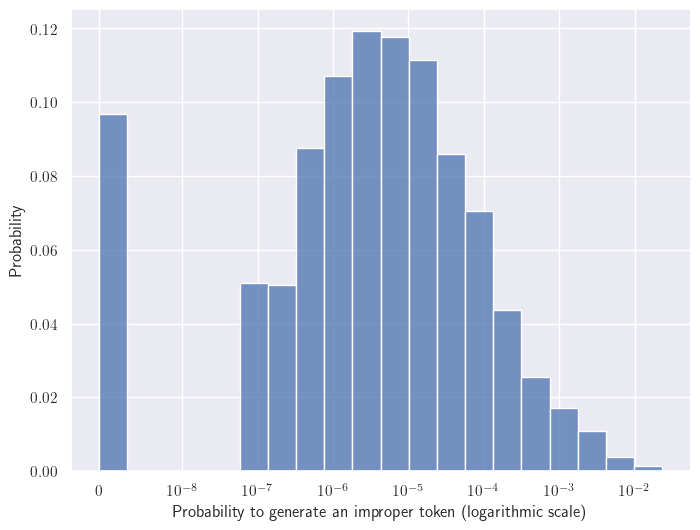

In [ ]:
plt.xscale('symlog', linthresh=1e-8)
sns.histplot(
    [1-proba_proper_tokenization[i] for i in range(len(proba_proper_tokenization)) if num_forbidden[i] > 0],
    bins=20,
    stat="probability"
)
_ = plt.xlabel("Probability to generate an improper token (logarithmic scale)")

# Vegas configurations

We look for Vegas configurations in the sense given in the last section of the blog post.

In [ ]:
def mergeable(string, merge_table, direction):
    """
    Identify with which characters a token can be merged.
    """
    result = set()
    for s in merge_table:
        if string in s:
            if direction in ["right", "both"]:
                splitted = s.replace(" ", "").split(string)
                for split in splitted[1:]:
                    if len(split) > 0:
                        result.add(split[0])
            if direction in ["left", "both"]:
                splitted = s.replace(" ", "").split(string)
                for split in splitted[:-1]:
                    if len(split) > 0:
                        result.add(split[-1])
    return result

A line break does not merge with anything (interesting for YAML schemas).

In [ ]:
" ".join(mergeable('\n', tokenizer_dict["model"]["merges"], "both"))

''

A colon break does not merge with a blank space at its right (interesting for JSON and YAML schemas).

In [ ]:
" ".join(mergeable(":", tokenizer_dict["model"]["merges"], "right"))

'* / } _ = , \r - < ~ ] \' ` " % \\ $ ) {'

Digits do not merge with anything (interesting for numeric types in JSON or YAML schemas).

In [ ]:
" ".join([" ".join(mergeable(str(i), tokenizer_dict["model"]["merges"], "both")) for i in range(10)])

'         '

`",` (which is a token) does not merge with a blank space at its right (interesting for string types in JSON schemas).

In [ ]:
" ".join(mergeable('",', tokenizer_dict["model"]["merges"], "right"))

'\r "'